# Data quality check (QC)

## 1) Import

In [1]:
import os, glob, math
import numpy as np
import pandas as pd
import wfdb
import neurokit2 as nk
from scipy.signal import welch
import matplotlib.pyplot as plt


## 2) Hàm tiện ích: đọc 1 record WFDB

In [2]:
def load_record(record_path_no_ext: str):
    """
    record_path_no_ext: đường dẫn KHÔNG kèm đuôi (vd: 'data/rec_0001', không phải 'rec_0001.hea')
    Trả về: rec (wfdb Record), fs, leads (list), p_signal (ndarray, shape [T, n_leads], đơn vị vật lý mV)
    """
    rec = wfdb.rdrecord(record_path_no_ext, channels=None, physical=True)
    fs = float(rec.fs)
    leads = list(rec.sig_name) if rec.sig_name is not None else [f"L{i}" for i in range(rec.n_sig)]
    p_signal = rec.p_signal  # dạng vật lý (mV) nếu header đủ thông tin (thường là đủ)
    return rec, fs, leads, p_signal

# Ví dụ thử đọc 1 record
rec, fs, leads, p = load_record("../../../data/raw/autonomic-aging-a-dataset/0001")
print(fs, leads, p.shape)


1000.0 ['ECG1', 'ECG2', 'NIBP'] (900401, 3)


Cho thấy:

* File record đọc thành công với **tần số lấy mẫu fs = 1000 Hz**.
* Có **3 kênh tín hiệu**: `ECG1`, `ECG2`, `NIBP`.
* Ma trận tín hiệu `p` có shape **(900401, 3)** → ~900.4 giây ≈ **15 phút** ghi liên tục cho 3 kênh.


## 3) Kiểm tra metadata từ .hea (độ dài, fs, số lead,…)

In [3]:
def check_metadata(rec):
    meta = {
        "n_leads": int(rec.n_sig),
        "fs": float(rec.fs),
        "sig_len": int(rec.sig_len),
        "duration_s": float(rec.sig_len / rec.fs),
        "lead_names": ",".join(rec.sig_name) if rec.sig_name is not None else "",
    }
    return meta

# Ví dụ:
meta = check_metadata(rec)
meta


{'n_leads': 3,
 'fs': 1000.0,
 'sig_len': 900401,
 'duration_s': 900.401,
 'lead_names': 'ECG1,ECG2,NIBP'}

* Record có **3 kênh** (`ECG1, ECG2, NIBP`) với **fs = 1000 Hz**.
* Độ dài tín hiệu: **900401 mẫu** → **900.401 giây (~15 phút)** ghi liên tục.


## 4) Đánh giá chất lượng tín hiệu ECG bằng phương pháp zhao2018

**Thông tin từ:** https://neuropsychology.github.io/NeuroKit/functions/ecg.html#ecg-analyze


"The "zhao2018" method (Zhao et al., 2018) extracts several signal quality indexes (SQIs): QRS wave power spectrum distribution pSQI, kurtosis kSQI, and baseline relative power basSQI. An additional R peak detection match qSQI was originally computed in the paper but left out in this algorithm. The indices were originally weighted with a ratio of [0.4, 0.4, 0.1, 0.1] to generate the final classification outcome, but because qSQI was dropped, the weights have been rearranged to [0.6, 0.2, 0.2] for pSQI, kSQI and basSQI respectively."

returns string classification (Unacceptable, Barely acceptable or Excellent) of the signal for "zhao2018" method.

#### Demo trên ecg 0001

In [4]:
import neurokit2 as nk


rec, fs, leads, p = load_record("../../../data/raw/autonomic-aging-a-dataset/0001")
meta = check_metadata(rec)

x = p[:, 0]

quality = nk.ecg_quality(x, sampling_rate=1000, method='zhao2018')
print(quality)

Excellent


#### Duyệt toàn bộ folder

In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
import neurokit2 as nk
from tqdm.auto import tqdm
import warnings

root = Path("../../../data/raw/autonomic-aging-a-dataset")

rows = []
warn_rows = []  # lưu danh sách ECG có cảnh báo thiếu điểm dữ liệu

hea_files = sorted(root.glob("*.hea"))

for hea_path in tqdm(hea_files, desc="Scanning ECG", unit="file"):
    name_ecg = hea_path.stem
    record_path_no_ext = hea_path.with_suffix("")
    dat_path = hea_path.with_suffix(".dat")

    if not dat_path.exists():
        # thiếu .dat → bỏ qua
        continue

    try:
        rec, fs, leads, p = load_record(str(record_path_no_ext))
    except FileNotFoundError as e:
        # lỗi đọc record → bỏ qua
        continue

    x = p[:, 0]

    # Đếm NaN trong tín hiệu thô
    n_missing_raw = int(np.isnan(x).sum())

    # Bắt và gom cảnh báo từ neurokit2.ecg_clean (không in ra console)
    with warnings.catch_warnings(record=True) as wlist:
        warnings.simplefilter("always")
        ecg_cleaned = nk.ecg_clean(x, sampling_rate=fs)

    # Nếu có cảnh báo "missing data points" HOẶC có NaN trong x → log lại
    warn_msgs = [str(w.message) for w in wlist]
    if n_missing_raw > 0 or any("missing data points" in m.lower() for m in warn_msgs):
        warn_rows.append({
            "name_ecg": name_ecg,
            "n_missing_raw": n_missing_raw,
            "warnings": " | ".join(sorted(set(warn_msgs))),
        })

    # Tính quality (fuzzy như chị đang dùng)
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=fs, method="zhao2018", approach="fuzzy")
    # quality = nk.ecg_quality(ecg_cleaned, sampling_rate=fs, method="zhao2018")
    if quality in ["Unacceptable", "Barely acceptable"]:
        rows.append({"name_ecg": name_ecg, "quality": quality})

# Kết quả quality
df_quality = pd.DataFrame(rows)
df_quality.to_csv("ecg_quality_fuzzy.csv", index=False)
print(f"[OK] Saved quality -> ecg_quality_fuzzy.csv ({len(df_quality)} rows)")

# Danh sách ECG có cảnh báo thiếu dữ liệu
if warn_rows:
    df_warn = pd.DataFrame(warn_rows).sort_values(["n_missing_raw", "name_ecg"], ascending=[False, True])
    df_warn.to_csv("ecg_warnings_missing_points.csv", index=False)
    print(f"[OK] Saved warnings -> ecg_warnings_missing_points.csv ({len(df_warn)} rows)")
    # In nhanh top 10 để xem
    print(df_warn.head(10))
else:
    print("[INFO] Không có ECG nào phát sinh cảnh báo thiếu điểm dữ liệu.")


Scanning ECG:   0%|          | 0/1119 [00:00<?, ?file/s]


KeyboardInterrupt



Note: ko có file 0400.dat

## Sơ lược về cách đánh giá chất lượng
Dựa trên bài báo: *SQI quality evaluation mechanism of single-lead ECG signal based on simple heuristic fusion and fuzzy comprehensive evaluation*

Lưu ý: thông tin dưới đây được tóm tắt bằng Notebook LM

TÓM TẮT:

Tài liệu này là một bài báo nghiên cứu gốc, được xuất bản vào tháng 6 năm 2018 trên tạp chí **Frontiers in Physiology**, đề xuất một cơ chế đánh giá chất lượng tín hiệu điện tâm đồ (ECG) một đạo trình. Hệ thống này được thiết kế để đánh giá chất lượng tín hiệu ECG bằng cách sử dụng **kết hợp kinh nghiệm đơn giản** và **đánh giá toàn diện mờ (Fuzzy Comprehensive Evaluation)**. Phương pháp này bao gồm việc định lượng và trích xuất các **Chỉ số Chất lượng Tín hiệu (SQIs)** khác nhau, sau đó tiến hành phân loại thông minh. Các tác giả đã thử nghiệm thuật toán trên cơ sở dữ liệu ECG Physionet và đạt được **độ chính xác cao**, chứng minh rằng phương pháp này có thể hỗ trợ hiệu quả trong việc thu thập ECG trên thiết bị di động và chẩn đoán lâm sàng sớm. Cuối cùng, nghiên cứu này còn so sánh hiệu suất của thuật toán được đề xuất với các phương pháp đánh giá chất lượng ECG hiện có khác.

Nguồn tài liệu cung cấp một cơ chế đánh giá và phân loại chất lượng tín hiệu điện tâm đồ (ECG) thành **một số cấp độ khác nhau**.

Cụ thể, cơ chế đánh giá dựa trên sự kết hợp giữa thuật toán heuristic đơn giản (Simple Heuristic Fusion) và Đánh giá Toàn diện Mờ (Fuzzy Comprehensive Evaluation) đã phân loại chất lượng tín hiệu ECG thành **ba mức độ chính**.

Tập hợp các cấp độ đánh giá chất lượng ECG ($V$) được định nghĩa là:

1.  **Excellent (E)** (Tuyệt vời).
2.  **Barely acceptable (B)** (Chấp nhận được một cách khó khăn).
3.  **Unacceptable (U)** (Không thể chấp nhận được).

### Chi tiết về Cơ chế Phân loại

Cơ chế phân loại này được áp dụng trong cả hai phương pháp được mô tả trong tài liệu: Kết hợp Heuristic Đơn giản (Simple Heuristic Fusion) và Đánh giá Toàn diện Mờ (Fuzzy Comprehensive Evaluation).

#### 1. Phân loại bằng Kết hợp Heuristic Đơn giản

Sự kết hợp đơn giản các Chỉ số Chất lượng Tín hiệu (SQIs) phân loại tín hiệu thành ba cấp độ (E, B, U). Các tiêu chí phân loại dựa trên sự kết hợp logic của việc các chỉ số SQI cá nhân được đánh giá là 'optimal' (tối ưu), 'suspicious' (đáng ngờ), hay 'unqualified' (không đạt yêu cầu).

Ví dụ, khi sử dụng hai chỉ số SQI ($SQI_1, SQI_2$), tín hiệu được phân loại như sau:

*   **Excellent (E)**: Nếu có 2 chỉ số là 'optimal'.
*   **Barely acceptable (B)**: Nếu có 2 chỉ số là 'suspicious' HOẶC 1 chỉ số là 'optimal' và 1 chỉ số là 'suspicious'.
*   **Unacceptable (U)**: Các trường hợp khác.

#### 2. Phân loại bằng Đánh giá Toàn diện Mờ (Fuzzy Comprehensive Evaluation)

Phương pháp này sử dụng **nguyên tắc ra quyết định trọng số trung bình** (principle of weighted average decision-making) để tính toán một giá trị tổng hợp ($v$) dựa trên các chỉ số SQI tốt nhất được chọn lọc ($U = \{qSQI, pSQI, kSQI, basSQI\}$).

Sau khi tính toán giá trị $v$ theo công thức (33), việc phân loại chất lượng ECG được thực hiện bằng cách sử dụng các ngưỡng định sẵn:

*   **Excellent (E)**: Khi $v \leq 1.50$.
*   **Barely acceptable (B)**: Khi $1.50 < v < 2.40$.
*   **Unacceptable (U)**: Khi $v \geq 2.40$.

### Hành động Tương ứng với Từng Cấp độ

Sau khi tín hiệu được phân loại, các hành động cụ thể được đề xuất:

| Cấp độ | Tình trạng Chất lượng | Hành động Đề xuất |
| :--- | :--- | :--- |
| **Excellent (E)** | Chất lượng tín hiệu tốt. | Tín hiệu có thể được **trực tiếp đưa vào** ứng dụng nhận dạng, giám sát an ninh hoặc các ứng dụng khác. |
| **Unacceptable (U)** | Chất lượng tín hiệu kém. | **Phân tích 4 SQIs**: Nếu kSQI hoặc basSQI không đạt yêu cầu, nhiễu hiện diện, cần **khử nhiễu** trước rồi đánh giá lại. Nếu pSQI hoặc qSQI không đạt yêu cầu, cần **thu thập lại** ECG của người kiểm tra. |
| **Barely acceptable (B)** | Chất lượng tín hiệu ở mức trung gian. | Chất lượng ECG nên được **đánh giá lại**. Nếu kết quả là E, tín hiệu được xử lý như phương pháp của E. Nếu không, tín hiệu được xử lý như phương pháp của U. |

Mặc dù tài liệu cũng đề cập đến việc phân biệt giữa ECG **chất lượng cao và chất lượng kém**, nhưng hệ thống đề xuất nhằm mục đích thiết lập một cơ chế đánh giá phù hợp chia kết quả tín hiệu thành nhiều cấp độ khác nhau, với ba mức độ cụ thể là E, B, và U.

Dựa trên nguồn tài liệu, **Đánh giá Toàn diện Mờ (Fuzzy Comprehensive Evaluation)** đã cho thấy **hiệu suất tốt hơn** so với **Kết hợp Heuristic Đơn giản (Simple Heuristic Fusion)** trong việc đánh giá chất lượng tín hiệu ECG.

Phương pháp được đề xuất trong tài liệu là sự kết hợp của cả hai cơ chế, trong đó **Kết hợp Heuristic Đơn giản** được sử dụng ở **Bước 1** để chọn ra tập hợp Chỉ số Chất lượng Tín hiệu (SQIs) tối ưu, và sau đó **Đánh giá Toàn diện Mờ** được áp dụng ở **Bước 2** để thực hiện phân loại thông minh và chính xác hơn.

Dưới đây là so sánh chi tiết về hiệu suất giữa hai phương pháp này, tập trung vào kết quả kiểm tra (Test performance) trên hai bộ cơ sở dữ liệu độc lập (Database D1 và D2):

### 1. Kết quả Hiệu suất Kiểm tra (Test Performance)

Các bảng so sánh hiệu suất cho thấy Đánh giá Toàn diện Mờ có độ chính xác (Accuracy - Acc) và độ nhạy (Sensitivity - Se) cao hơn trong hầu hết các trường hợp, đặc biệt khi sử dụng tập hợp 4 SQIs tốt nhất ($U = \{qSQI, pSQI, kSQI, basSQI\}$).

#### Trên Database D1:

| Phương pháp | SQIs tham gia | Acc (%) | Se (%) | Sp (%) |
| :--- | :--- | :--- | :--- | :--- |
| Simple Heuristic Fusion (4 SQIs) | 4 | 84.33 | 88.67 | 81.33 |
| Simple Heuristic Fusion (5 SQIs) | 5 | 87.00 | 88.67 | 87.33 |
| **Fuzzy Comprehensive Evaluation** | **4** | **92.67** | **97.33** | 88.67 |

**Nhận xét trên D1:**
*   Đánh giá Toàn diện Mờ (4 SQIs) đạt **độ chính xác cao nhất (92.67%)** và **độ nhạy cao nhất (97.33%)**.

#### Trên Database D2:

| Phương pháp | SQIs tham gia | Acc (%) | Se (%) | Sp (%) |
| :--- | :--- | :--- | :--- | :--- |
| Simple Heuristic Fusion (4 SQIs) | 4 | 91.33 | 93.67 | 92.67 |
| Simple Heuristic Fusion (5 SQIs) | 5 | 89.67 | 91.00 | 88.33 |
| **Fuzzy Comprehensive Evaluation** | **4** | **94.67** | 90.33 | **93.00** |

**Nhận xét trên D2:**
*   Đánh giá Toàn diện Mờ (4 SQIs) đạt **độ chính xác cao nhất (94.67%)** và **độ đặc hiệu cao nhất (93.00%)**.

### 2. Ưu điểm của Đánh giá Toàn diện Mờ

Tài liệu khẳng định rằng việc tổng hợp các chỉ số SQI thông qua **Đánh giá Toàn diện Mờ** đã **cải thiện độ chính xác** trên cả Database D1 và D2 so với phương pháp Kết hợp Heuristic Đơn giản, ngay cả khi sử dụng cùng một số lượng chỉ số SQI.

*   **Tính toàn diện và độ chính xác cao hơn:** Đánh giá Toàn diện Mờ dựa trên nguyên lý tổng hợp quan hệ mờ (fuzzy relational synthesis), cho phép **lượng hóa các yếu tố không xác định và không thể định lượng**.
*   **Sử dụng Trọng số:** Phương pháp này tính đến **trọng số (weight vector W)** của các yếu tố khác nhau (SQIs) đối với chất lượng tín hiệu ECG, giúp phản ánh mức độ quan trọng khác nhau của chúng và mang lại kết quả đánh giá cuối cùng chính xác hơn.
*   **Sử dụng Hàm Thành viên (Membership Function):** Đánh giá Toàn diện Mờ tính toán mức độ thành viên (membership) của từng yếu tố SQI đối với các cấp độ chất lượng (Excellent, Barely acceptable, Unacceptable) bằng cách sử dụng các hàm phân phối khác nhau (Cauchy, hình thang, hình chữ nhật), giúp xử lý các ranh giới chất lượng không rõ ràng một cách hiệu quả.

### 3. Hạn chế của Kết hợp Heuristic Đơn giản

Mặc dù Kết hợp Heuristic Đơn giản là một bước quan trọng để chọn lọc các SQI tốt nhất, nhưng nó có những hạn chế sau:

*   **Logic mang tính kinh nghiệm (Empirical Logic):** Các quy tắc phân loại của phương pháp này (Equations 13–16) là "tùy ý và được thiết lập theo kinh nghiệm thông qua thử và sai". Tài liệu thừa nhận rằng **không chắc chắn** logic này là tối ưu.
*   **Hiệu suất giới hạn:** Mặc dù độ chính xác tăng lên khi số lượng SQIs tăng từ 2 lên 5, sự gia tăng này chậm và đôi khi việc thêm SQI mới (như cSQI) lại không tối ưu hóa tốt độ chính xác, độ nhạy và độ đặc hiệu.
*   **Mô hình hai cấp độ:** Khi so sánh hiệu suất, Kết hợp Heuristic Đơn giản được sử dụng chủ yếu để xác định tổ hợp SQI tốt nhất trước khi chuyển sang bước phân loại phức tạp hơn.

**Tóm lại:**

Đánh giá Toàn diện Mờ được thiết kế để cung cấp một **đánh giá và phân loại chính xác hơn** (mô-đun Phân loại Thông minh) so với Kết hợp Heuristic Đơn giản (mô-đun Lượng hóa và Trích xuất SQI ban đầu), điều này được xác nhận qua các kết quả thực nghiệm với độ chính xác cao hơn rõ rệt (ví dụ, tăng từ 87.00% lên 92.67% trên D1 và từ 91.33% lên 94.67% trên D2 khi sử dụng 4 SQIs).

Bạn có thể hình dung sự khác biệt này giống như việc sử dụng **một bộ quy tắc đơn giản** (Simple Heuristic Fusion) để phân loại các món ăn dựa trên hai hoặc ba đặc điểm cơ bản, so với việc sử dụng **một hệ thống đánh giá của chuyên gia có trọng số và khả năng xử lý các ranh giới mờ** (Fuzzy Comprehensive Evaluation), hệ thống sau sẽ đưa ra kết quả phân loại chính xác và tinh tế hơn.

### Kiểm tra Nhóm ID có chất lượng dữ liệu thấp

In [13]:
import pandas as pd
        
subject_reduced = pd.read_csv('../../../data/processed/subject_reduced.csv', dtype = {"ID": str})
subject_reduced

,ID,Age_group_reduced,BMI,Sex
0,0001,0,23.0,1.0
1,0002,0,24.0,1.0
2,0003,2,28.0,1.0
3,0004,1,24.0,0.0
4,0005,0,20.0,1.0
...,...,...,...,...
1088,1117,0,22.0,1.0
1089,1118,3,32.0,1.0
1090,1119,0,26.0,0.0
1091,1120,0,27.0,0.0


In [14]:
import pandas as pd
        
ecg_quality_Simple = pd.read_csv('ecg_quality_Simple.csv', dtype = {"name_ecg": str})
ecg_quality_Simple
df_q = ecg_quality_Simple.rename(columns={"name_ecg": "ID"})
df_q

,ID,quality
0,0002,Barely acceptable
1,0003,Barely acceptable
2,0004,Barely acceptable
3,0005,Barely acceptable
4,0007,Unacceptable
...,...,...
804,1115,Barely acceptable
805,1116,Barely acceptable
806,1119,Barely acceptable
807,1120,Barely acceptable


In [21]:
df_merged = subject_reduced.merge(df_q, how="left", left_on="ID", right_on="ID")
df_merged["quality"] = df_merged["quality"].fillna("Excellent")
df_merged


,ID,Age_group_reduced,BMI,Sex,quality
0,0001,0,23.0,1.0,Excellent
1,0002,0,24.0,1.0,Barely acceptable
2,0003,2,28.0,1.0,Barely acceptable
3,0004,1,24.0,0.0,Barely acceptable
4,0005,0,20.0,1.0,Barely acceptable
...,...,...,...,...,...
1088,1117,0,22.0,1.0,Excellent
1089,1118,3,32.0,1.0,Excellent
1090,1119,0,26.0,0.0,Barely acceptable
1091,1120,0,27.0,0.0,Barely acceptable


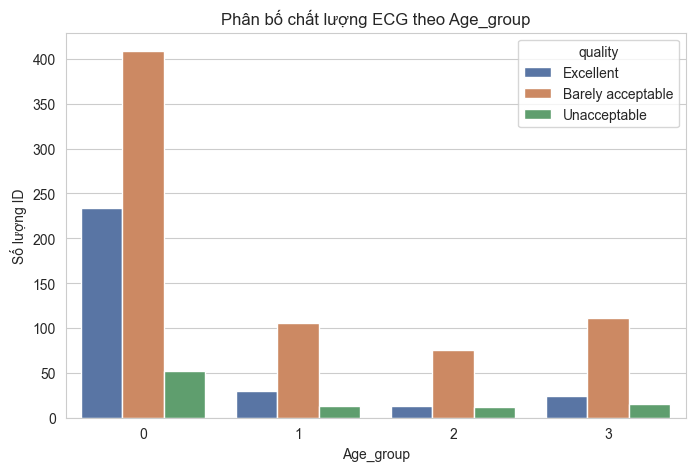

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(
    data=df_merged,
    x = "Age_group_reduced",
    hue = "quality",
    palette="deep",
)
plt.title("Phân bố chất lượng ECG theo Age_group")
plt.xlabel("Age_group")
plt.ylabel("Số lượng ID")
plt.show()

In [18]:
df_merged["quatity"]

KeyError: 'quatity'